The user will select a profile region (rectangle). The pixels in the smallest width of the rectangle will be added. Then the profile ploted for each of the image index. This will allow for example to follow the flow of water as it enters a crack.

## 1. Prepare logbook 

In [65]:
from ipywidgets import widgets
#from IPython.html import widgets
from IPython.display import display

from pprint import pprint
from ipywidgets.widgets import interact

import os, os.path
import datetime
import glob

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

import matplotlib as mpl
from PyQt5 import QtGui

font = {'family' : 'monospace',
       'size' : '14'}
mpl.rc('font', **font)

from PIL import Image
import numpy as np
import pandas as pd

from plotly.offline import plot, init_notebook_mode, iplot
init_notebook_mode()
import plotly
import plotly.graph_objs as go

## 2. Select Data Files

In [66]:
default_dir = '/HFIR/CG1DImaging/IPTS-16259/raw/radiographs/'

In [73]:
%gui qt

try:
    from PyQt4.QtGui import QFileDialog
except ImportError:
    from PyQt5.QtWidgets import QFileDialog

def gui_dname(dir=None):
    """Select a directory
    """
    if dir is None: dir ='./'
    dir_name = QFileDialog.getExistingDirectory(None, "Select Data Files Folder ...",
                                                   dir)
                                                 
    return dir_name

def gui_fname(dir=None):
    """
    select files
    """
    if dir is None: dir='./'
    file_names = QFileDialog.getOpenFileNames(None, "Select files ...",
                                            dir, filter = "Tiff (*.tiff);; All files (*)")
    return file_names

In [79]:
#%gui qt
#folder_name = gui_dname(dir = default_dir)
#list_files = glob.glob(folder_name + '/*.tiff')

%gui qt
list_files = gui_fname(dir=default_dir)
full_list_files = list_files[0]

## 3. Load the data 

to load all the data

    index_jump = 1

otherwise use a jumping parameter

    ex: 
        index_jump = 100     #will load file index 0, 100, 200, 300....


In [ ]:
index_jump = 100
list_files = [full_list_files[index] for index in np.arange(0, len(list_files), index_jump)] 

In [80]:
print("Number of files to load: {}".format(len(list_files)))

w = widgets.IntProgress()
w.max = len(list_files)
display(w)
index = 0

array_images = []
array_time_stamp = []
for ref, file in enumerate(list_files):
    _data = Image.open(file)
    
    # extract image
    _image = np.asarray(_data)
    array_images.append(_image)

    # extract metadata
    _metadata = _data.tag_v2.as_dict()
    acquisition_time = _metadata[65000]
    acquisition_time = acquisition_time[0]
    array_time_stamp.append(acquisition_time)
    
    index += 1
    w.value = index
    
w.close()

Number of files to load: 501


In [77]:
base_folder = os.path.dirname(list_files[0])
print("base folder: {}".format(base_folder))

base folder: /HFIR/CG1DImaging/IPTS-16259/raw/radiographs/Day-4-SW-6-uptake


## 4. Select Range of Image to Work On 

Using the Image Index (*image_index*) slider, narrow down the range of images that we will use in the analysis. Make sure you play wit the **min_intensity** and **max_intensity** to change the contrast of the images. 

### a. Default Contrast  and Profile Range

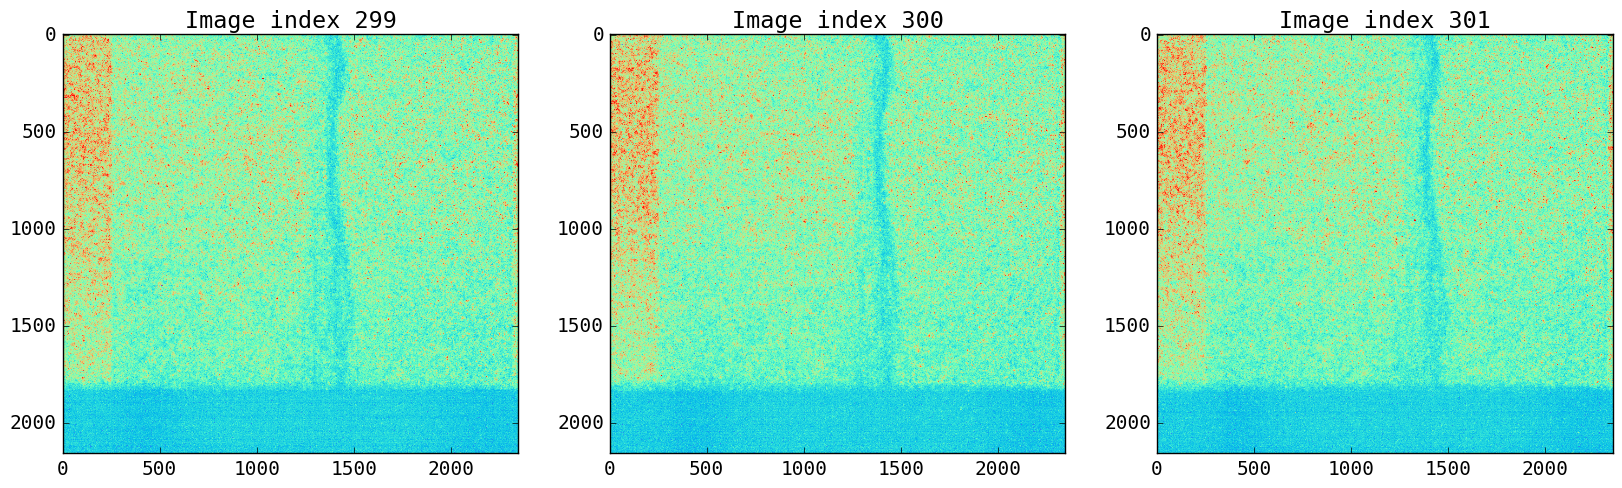

In [81]:
min_intensity = 82
max_intensity = 143

def plot_images(file_index):
    
    data_left = array_images[file_index-1]
    data      = array_images[file_index]
    data_right = array_images[file_index+1]
    
    fig = plt.figure(figsize=(20,20))
    gs = gridspec.GridSpec(1,3)
    
    ax_img = plt.subplot(gs[0,0])
    ax_img.imshow(data_left, cmap='rainbow', 
                  interpolation=None,
                  vmin=min_intensity, 
                  vmax=max_intensity)
    ax_img.set_title("Image index %d" %(file_index-1))

    ax_img = plt.subplot(gs[0,1])
    ax_img.imshow(data, cmap='rainbow', 
                  interpolation=None,
                  vmin=min_intensity, 
                  vmax=max_intensity)
#    ax_img.add_patch(patches.Rectangle((x_left, y_top), width, height, fill=False))
    ax_img.set_title("Image index %d" %file_index)
    

    ax_img = plt.subplot(gs[0,2])
    ax_img.imshow(data_right, cmap='rainbow', 
                  interpolation=None,
                  vmin=min_intensity, 
                  vmax=max_intensity)
    ax_img.set_title("Image index %d" %(file_index+1))
    

    
number_of_files = len(list_files)
range_selection = interact(plot_images,
                          file_index = widgets.IntSlider(min=1, 
                                                         max=number_of_files-2, 
                                                         value=35, 
                                                         step=1, 
                                                         description="Image Index"))


### b. Image range

Using previous plot, you determined that the range of images of interest is between:


In [82]:
first_image_index = 220
last_image_index = 300

In [83]:
[image_height, image_width] = array_images[0].shape
working_array_images = array_images[first_image_index : last_image_index+1]
working_list_files = list_files[first_image_index : last_image_index+1]
working_array_time_stamp = array_time_stamp[first_image_index: last_image_index+1]

## 5. Normalize data

The data will be all normalized by using the first image. Each image will be divided by the first image.

In [84]:
print(len(working_list_files))

81


In [85]:
normalization_file = working_list_files[0]
normalization_data = working_array_images[0]

_list_files = working_list_files

w = widgets.IntProgress()
w.max = len(_list_files)
display(w)
index = 0

normalized_array_images = []
for _image in working_array_images:
    _normalized_image = _image / normalization_data
    normalized_array_images.append(_normalized_image)
    index += 1
    w.value = index
    
w.close()

## 6. Define pixel size (mm) 

[238, 2300]

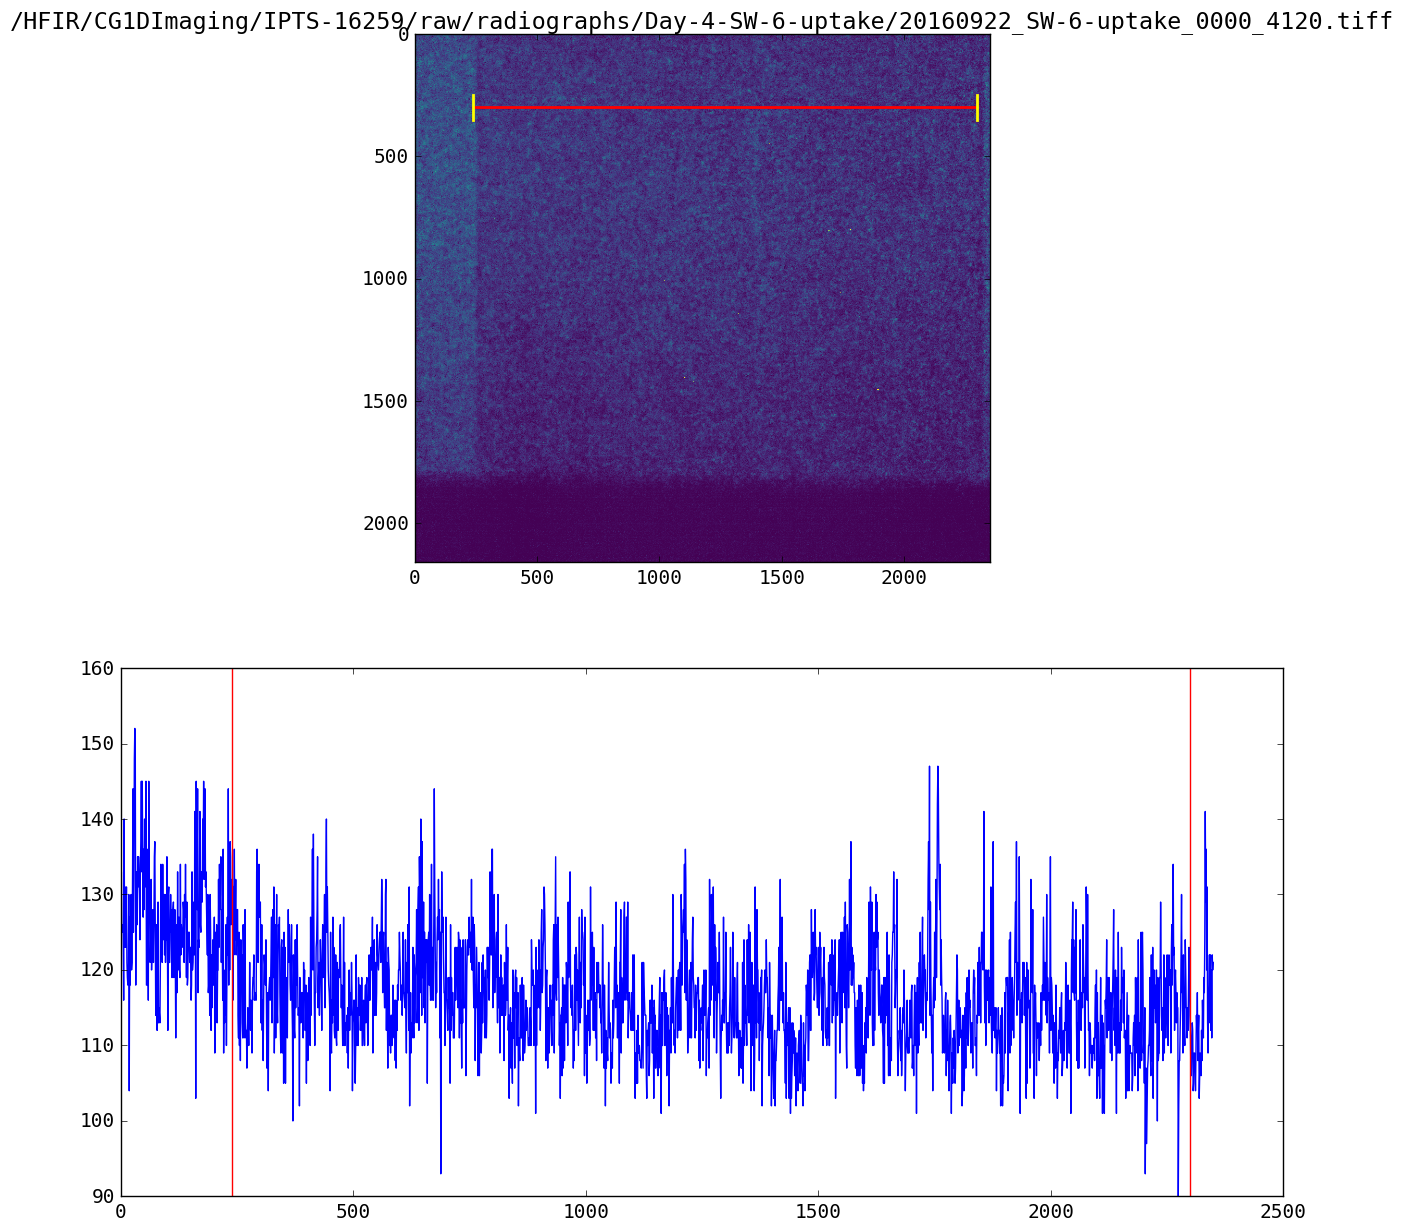

In [86]:
min_intensity = 100
max_intensity = 200

x0 = 238
x1 = image_width-50
y0 = 300

yoff_marker = 50

def plot_images_with_line(file_index, x0, x1, y):
    
    data = array_images[file_index][:, :]
    line1 = [[x0, y], [x1, y]]
    (line1_xs, line1_ys) = zip(*line1)
    
    #marker
    line2 = [[x0,y-yoff_marker], [x0, y+yoff_marker]]
    (line2_xs, line2_ys) = zip(*line2)
    line3 = [[x1,y-yoff_marker], [x1, y+yoff_marker]]
    (line3_xs, line3_ys) = zip(*line3)
    
    fig_box = plt.figure(figsize=(15, 15))
    ax_img = plt.subplot(211)
    
    ax_img.imshow(data, cmap = 'viridis',
                  interpolation = None,
                  vmin = min_intensity,
                  vmax = max_intensity)
    ax_img.add_line(mpl.lines.Line2D(line1_xs, line1_ys, linewidth=2, color='red'))
    ax_img.add_line(mpl.lines.Line2D(line2_xs, line2_ys, linewidth=2, color='yellow'))
    ax_img.add_line(mpl.lines.Line2D(line3_xs, line3_ys, linewidth=2, color='yellow'))
    ax_img.set_title(working_list_files[file_index])
    
    ax_plt = plt.subplot(212)
    _profile = data[y,:]
    ax_plt.plot(_profile)
    ax_plt.axvline(x=x0, c="red", linewidth=1)
    ax_plt.axvline(x=x1, c="red", linewidth=1)
    
    return [x0, x1]

number_of_files = len(list_files)
profile = interact(plot_images_with_line,
                  file_index = widgets.IntSlider( min=0, 
                                                 max=len(working_list_files), 
                                                 value=0, 
                                                 step=1, 
                                                 description='Image index'),
                  x0 = widgets.IntSlider( min=0, max=image_width-1, 
                                             step=1, value= x0),
                 x1 = widgets.IntSlider( min=0, max=image_width-1, 
                                             step=1, value= x1),
                  y = widgets.IntSlider(min=0, 
                                       max=image_height-1,
                                       step=1,
                                       value=y0))
  

#### Range selected in mm

In [87]:
print("x0: {}".format(x0))
print("x1: {}".format(x1))

x0: 238
x1: 2300


In [88]:
dim_mm = 25.40
pixel_size = dim_mm/(x1-x0)
print("Pixel size is {} mm/pixel".format(pixel_size))

Pixel size is 0.012318137730358874 mm/pixel


## 7. Select Profile Region 

default_profile_range

In [89]:
min_intensity = 0
max_intensity = 1

image_index_value = 27
x_left = 1234
y_top = 0
_width = 37
_y_bottom = 2106

[1340, 0, 2350, 2160, <matplotlib.figure.Figure at 0x7f943f181f28>]

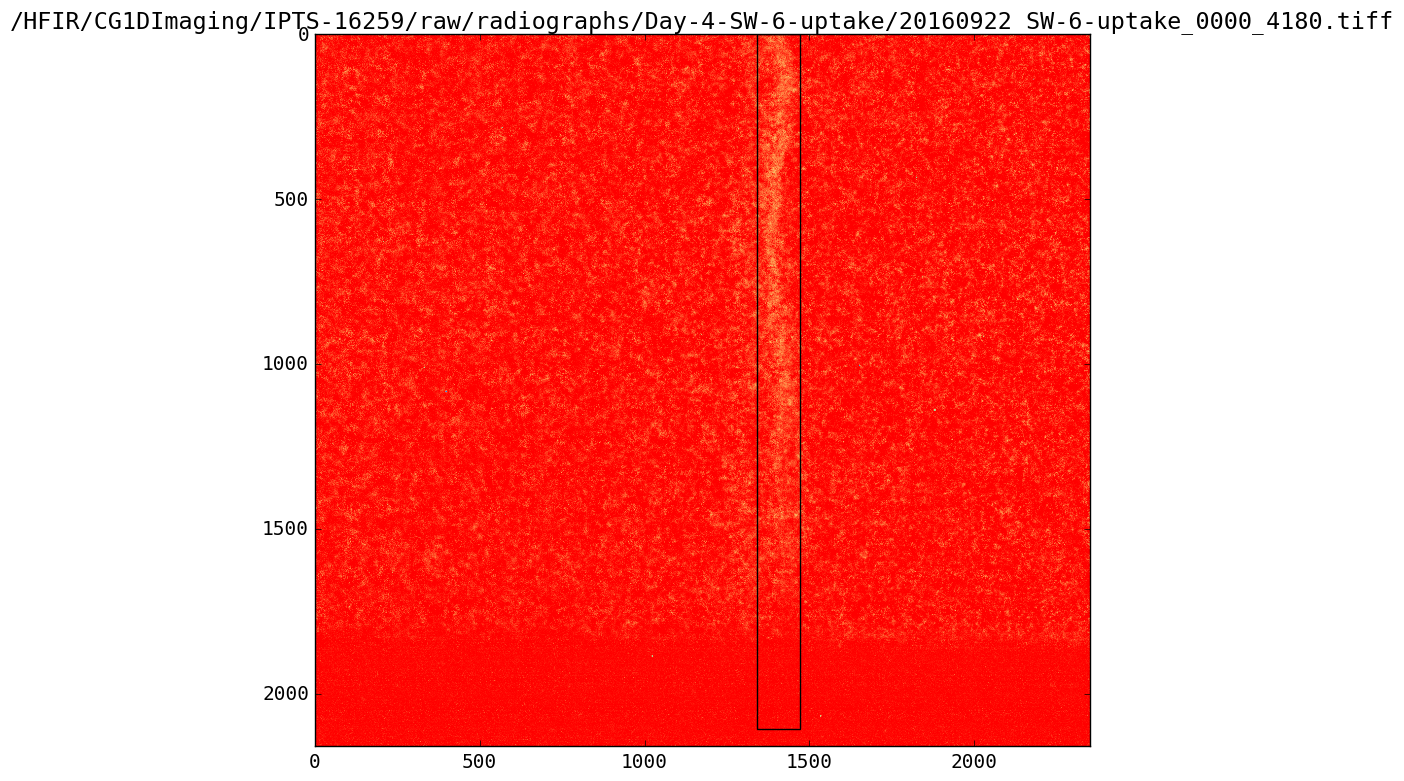

In [90]:
def plot_images_with_box(file_index, x_left, width, y_top, y_bottom):
    
    data = normalized_array_images[file_index][:, :]
    
    fig_box = plt.figure(figsize=(10, 10))
    ax_img = plt.subplot(111)
    
    ax_img.imshow(data, cmap = 'rainbow',
                  interpolation = None,
                  vmin = min_intensity,
                  vmax = max_intensity)
    ax_img.set_title(working_list_files[file_index])
    ax_img.add_patch(patches.Rectangle((x_left, y_top), width, (y_bottom-y_top), fill=False))
    
    return [x_left, y_top, image_width, image_height, fig_box]

number_of_files = len(list_files)
profile = interact(plot_images_with_box,
                  file_index = widgets.IntSlider( min=0, 
                                                 max=len(working_list_files), 
                                                 value=image_index_value, 
                                                 step=1, 
                                                 description='Image index'),
                  x_left = widgets.IntSlider( min=0, max=image_width-1, 
                                             step=1, value= x_left),
                  width = widgets.IntSlider( min=0, max=image_width-1, 
                                            step=1, value= _width), 
                  y_top = widgets.IntSlider( min=0, max=image_width-1, 
                                            step=1, value= y_top),
                  y_bottom = widgets.IntSlider(min=0, max=image_height-1, 
                                               step=1, value= _y_bottom))

    

## 8. calculate profile over range of images 

In [91]:
print(profile.widget.kwargs)
y_top = profile.widget.kwargs['y_top']
x_left = profile.widget.kwargs['x_left']
width = profile.widget.kwargs['width']
y_bottom = profile.widget.kwargs['y_bottom']
height = y_bottom - y_top

{'x_left': 1340, 'file_index': 60, 'width': 130, 'y_bottom': 2106, 'y_top': 0}


In [92]:
w = widgets.IntProgress()
w.max = len(working_list_files)-1
display(w)
index = 0

profile_array = []
for _image in normalized_array_images:
    _profile_image = _image[y_top:y_bottom, x_left:x_left+width]
    _value = np.sum(_profile_image)
    profile_array.append(_value)
    w.value = index
    index += 1
    
w.close()

## 9. Display global profile 

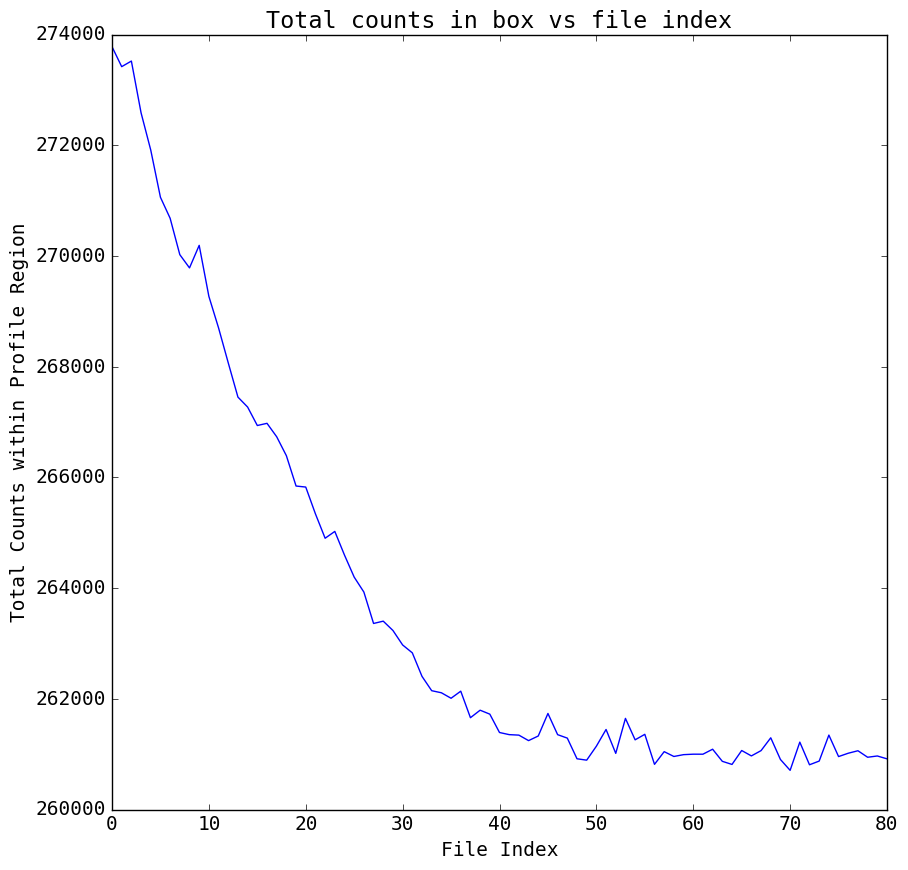

In [93]:
fig_profile = plt.figure(figsize=(10, 10))
plt.plot(profile_array)  
plt.title("Total counts in box vs file index")
plt.xlabel("File Index")
plt.ylabel("Total Counts within Profile Region")

## 10. Display Profile vs File Index  

In order to improve the statitics, **rebin** allows to combine those pixels in the y-direction. 

In [94]:
rebin = 1  #number of pixels in y direction to rebin (to improve statistic)

Calculate the profile
 - rebin the pixels as defined by the **rebin** parameter along the y-axis
 - sum all the pixels along the x-axis

In [95]:
w = widgets.IntProgress()
w.max = len(working_list_files)-1
display(w)
index = 0
rebin_range = np.arange(0, image_height-y_top, rebin)

profile_1d = []
def calculate_1d_profiles():
    
    for _index, _array in enumerate(normalized_array_images):
        _roi_array = _array[y_top:y_top+height, x_left:x_left+width]
        _width_profile = np.sum(_roi_array,1)
        rebin_width_profile = [sum(_width_profile[x:x+rebin]) for x in rebin_range]
        profile_1d.append(rebin_width_profile)
        _index += 1
        w.value = _index
    
calculate_1d_profiles()
w.close()

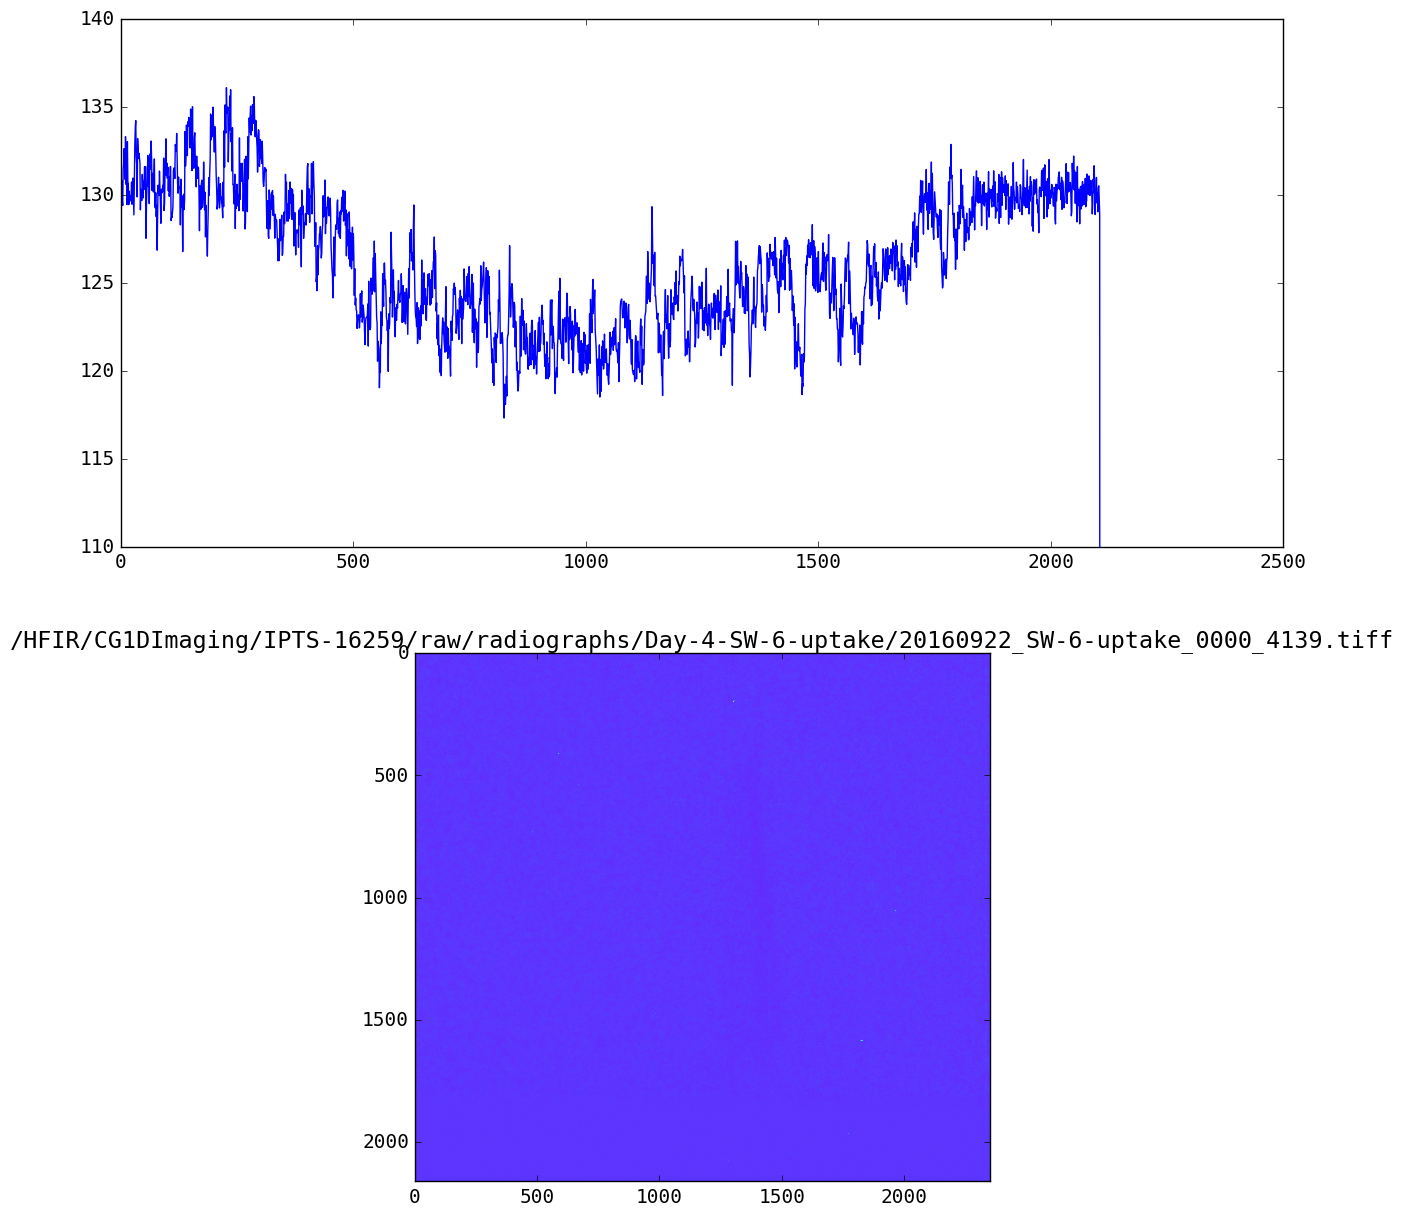

In [99]:
counts_max = 140
counts_min = 110

def plot_profile(file_index):
    
    data_1d = profile_1d[file_index]
    data_2d = normalized_array_images[file_index]
    
    fig = plt.figure(figsize=(15,15))
    
    plt.subplot(211)
    plt.plot(data_1d)
    plt.ylim([counts_min, counts_max])
    
    ax_img = plt.subplot(212)
    ax_img.imshow(data_2d, cmap = 'rainbow',
                  interpolation = None)
                  #vmin = min_intensity,
                  #vmax = max_intensity)
    ax_img.set_title(working_list_files[file_index])

number_of_files = len(working_list_files)
range_selection = interact(plot_profile,
                          file_index = widgets.IntSlider(min=0, 
                                                         max=number_of_files-1, 
                                                         value=5, 
                                                         step=1, 
                                                         description="Image Index"))

## 11. Calculation of Water Intake Peak 

In [100]:
class MeanRangeCalculation(object):
    '''
    Mean value of all the counts between left_pixel and right pixel
    '''
    
    def __init__(self, data=None):
        self.data = data
        self.nbr_pixel = len(self.data)
        
    def calculate_left_right_mean(self, pixel=-1):
        _data = self.data
        _nbr_pixel = self.nbr_pixel
        
        self.left_mean = np.mean(_data[0:pixel+1])
        self.right_mean = np.mean(_data[pixel+1:_nbr_pixel])
        
    def calculate_delta_mean_square(self):
        self.delta_square = np.square(self.left_mean - self.right_mean)
        

In [101]:
w = widgets.IntProgress()
w.max = len(profile_1d)
display(w)
index = 0

nbr_pixel = len(profile_1d[0])-20

water_intake_peak = []
for _index, counts in enumerate(profile_1d):
        delta_array = []
        for _pixel in range(5, nbr_pixel-1):
            _o_range = MeanRangeCalculation(data=counts)
            _o_range.calculate_left_right_mean(pixel = _pixel)
            _o_range.calculate_delta_mean_square()
            delta_array.append(_o_range.delta_square)

        _peak_value = delta_array.index(max(delta_array[:]))
        water_intake_peak.append(_peak_value)
        
        w.value = _index+1

w.close()

In [103]:
text = ["index: {}".format(str(index)) for index in range(len(working_array_time_stamp))]
trace = go.Scatter(x = working_array_time_stamp,
                   y = water_intake_peak, 
                   text = text,
                   mode = 'markers+lines')

data = [trace]
layout = dict(xaxis = dict(title = 'time stamp (s)'),
             yaxis = dict(title = 'Water Intake Peak'),
             title = "Water Intake Peak vs Time Stamp (s)")
fig = go.Figure(data=data, layout=layout)
iplot(fig)

## 12. Plot only the range of interest

In [ ]:
# ref pixel is detemined by looking at the previous plot and using max value
ref_pixel = np.mean(np.mean(water_intake_peak[0:5]))
print("Ref pixel: {}".format(ref_pixel))

time_range_for_plot = working_array_time_stamp[7:28]
t0 = time_range_for_plot[0]
time_range_for_plot_ms = ["{}".format(t-t0) for t in time_range_for_plot]

y_value = [ref_pixel - x for x in water_intake_peak]
y_value_for_plot = y_value[7:28]
y_value_for_plot_mm = [y * pixel_size for y in y_value_for_plot]

trace = go.Scatter(x = time_range_for_plot_ms,
                   y = y_value_for_plot_mm,
                   text = text,
                   mode = 'markers+lines')

data = [trace]
layout = dict(xaxis = dict(title = 'time stamp (ms)'),
             yaxis = dict(title = 'Water Intake Position (mm)'),
             title = "Water Intake Position (mm) vs Time Stamp (ms)")
fig = go.Figure(data=data, layout=layout)
iplot(fig)


## 13. Output Data 

In [ ]:
from PyQt4 import QtCore, QtGui

def gui_fname(dir=None):
    """Select a file via a dialog and returns the file name.
    """
    if dir is None: dir ='./'
    fname = QtGui.QFileDialog.getSaveFileName(None, 
                                              "Select file...", 
                                             dir, 
                                              filter="Text Files (*.txt);; All files (*.*)")
    return fname

In [ ]:
%gui qt
full_fname = gui_fname(dir=default_dir)

In [ ]:
ascii_text = "# Source data: {}\n".format(folder_name.split('/')[-1])
ascii_text += '# time_stamp(ms), water_intake_position (mm)\n'
for _index in range(len(time_range_for_plot_ms)):
    _x_value = time_range_for_plot_ms[_index]
    _y_value = y_value_for_plot_mm[_index]
    ascii_text += "{}, {}\n".format(_x_value, _y_value)
    
f = open(full_fname, 'w')
f.write(ascii_text)
f.close()

### Clear memory

In [ ]:
del(array_images[:])
del(array_images)